# Research Progress Meeting 2020-03-18
<img src="https://upload.wikimedia.org/wikipedia/commons/f/fe/Oil_Siphon_%284885250078%29.jpg" alt="Kalamazoo River oil spill" style="width:45%"> 
Image: Kalamazoo River oil spill

## Purpose

My previous analyses focused mostly on incident counts and extends of pipeline networks. But both pipeline incidents and networks are heterogeneous. Many questions I received at the PhD Research Series focused on how much oil was being spilled, and whether leaks were being contained. Therefore, I now obtained data on both the amount of oil transported (in barrel-miles) and on the amount of oil spilled.

## Setup

In [1]:
library(tidyverse)
library(oildata)
library(DataAnalysisTools)
library(gridExtra)

── Attaching packages ─────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine



In [2]:
packageVersion("oildata")

[1] ‘1.0.9’

In [3]:
head(pipelines)

year,commodity,ID,name,offshore_share,on_offshore,hca,miles,volume_crude,volume_hvl,⋯,estimate_volume_all,volume_specific,estimate_volume_specific,incidents,significant_incidents,serious_incidents,incidents_volume,significant_incidents_volume,incidents_cost,significant_incidents_cost
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2008,crude,11733,Loop,0.2008889,total,38.25,112.5,40852116635,0,⋯,40852116635,40852116635,40852116635,0,0,0,0,0,0,0
2008,crude,11733,Loop,0.2008889,offshore,3.00,22.6,NA,NA,⋯,8206736320,NA,8206736320,0,0,0,0,0,0,0
2008,crude,11733,Loop,0.2008889,onshore,35.25,89.9,NA,NA,⋯,32645380315,NA,32645380315,0,0,0,0,0,0,0
2008,hvl,3156,Davis Gas Processing,0.0000000,total,1.00,30.0,0,48,⋯,48,48,48,0,0,0,0,0,0,0
2008,hvl,3156,Davis Gas Processing,0.0000000,offshore,0.00,0.0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2008,hvl,3156,Davis Gas Processing,0.0000000,onshore,1.00,30.0,0,48,⋯,48,48,48,0,0,0,0,0,0,0


### Transform

In [4]:
pipelines_year <- pipelines %>%
    filter(commodity %in% c("crude", "hvl", "rpp")) %>%
    group_by(year, on_offshore) %>%
    summarize(!!! oildata::pipelines_consolidation) %>%
    pivot_longer(cols = -c(year, on_offshore), names_to = "variable", values_to = "value")

glimpse(pipelines_year)

Observations: 945
Variables: 4
Groups: year [15]
$ year        <dbl> 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 2004, 200…
$ on_offshore <chr> "offshore", "offshore", "offshore", "offshore", "offshore…
$ variable    <chr> "hca", "miles", "volume_crude", "volume_hvl", "volume_rpp…
$ value       <dbl> 1.000900e+03, 5.085560e+03, NA, NA, NA, NA, 1.675448e+11,…


## About the data

In [5]:
unique(pipelines_year$variable)

[1] "hca"                          "miles"                       
 [3] "volume_crude"                 "volume_hvl"                  
 [5] "volume_rpp"                   "volume_other"                
 [7] "estimate_volume_crude"        "estimate_volume_hvl"         
 [9] "estimate_volume_rpp"          "estimate_volume_other"       
[11] "volume_all"                   "estimate_volume_all"         
[13] "volume_specific"              "estimate_volume_specific"    
[15] "incidents"                    "significant_incidents"       
[17] "serious_incidents"            "incidents_volume"            
[19] "significant_incidents_volume" "incidents_cost"              
[21] "significant_incidents_cost"

## Volume estimates

Prior to 2010, the PHMSA does not differentiate betwen on and offshroe pipeline miles. They do however provide separate columns on what volume is transported onshore and offshore. For the purpose of this inquiry, I constructed columns which contain the actual values for 2010 onward (or where available) and an approximation for other values. The approximation takes the value of the share of offshore (or onshore) to total pipeline miles multiplied by the total volume transported.

$v_{est\_off} = \frac{miles_{off}}{miles_{on} + miles_{off}} * v_{total}$

## How much oil is being transported and spilled?

### Looking at both onshore and offshore

#### Pipeline network

In [6]:
overview <- pipelines_year %>%
    filter(variable %in% c("miles", "volume_all", "estimate_volume_all", "estimate_volume_specific")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(on_offshore ~ variable, scales = "free") +
        geom_line()

options(repr.plot.width=8, repr.plot.height=6)

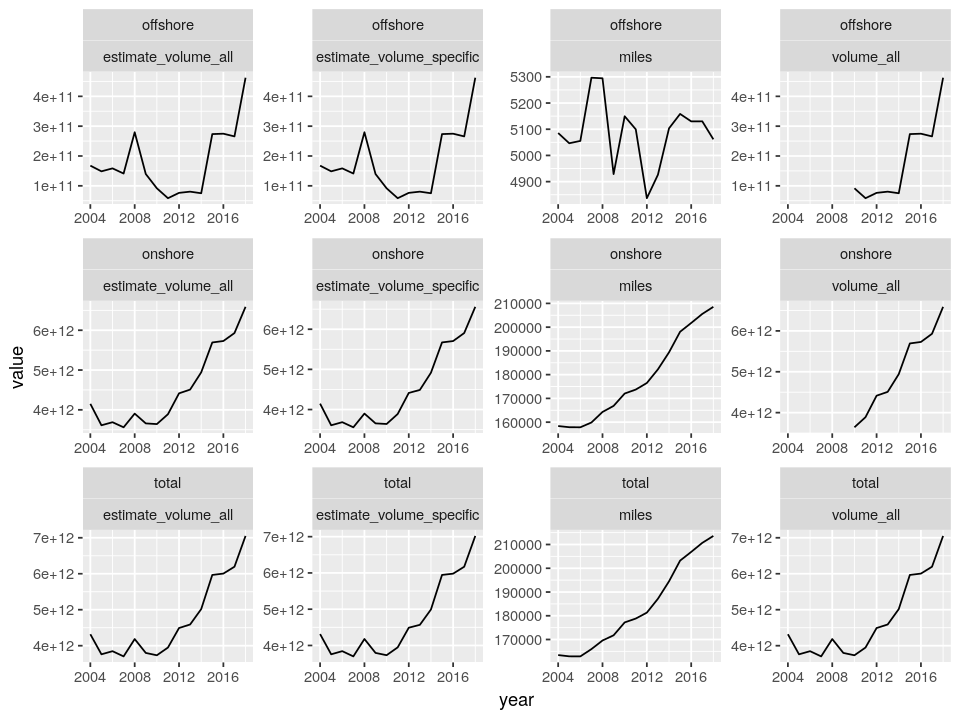

In [7]:
overview

We can see that the volume of oil transported does not at all follow a trend that is parallel to the number of pipeline miles. That might be both because of uncertainty in eventual output of oil wells, and because pipelines have different throughput (i.e., different diameter). 

One piece of good news is that estimate_volume_specific is very close to estimate_volume_all, so we will not have to worry about the difference between the two too much. The divergence comes about e.g., when a crude oil pipeline is used to temporarily transport crude.

#### Details

In [8]:
details_v_m <- pipelines_year %>%
    filter(on_offshore %in% c("total")) %>%
    filter(variable %in% c("miles", "estimate_volume_all")) %>%
    ggplot(aes(x = year, y = value)) +
        facet_wrap(on_offshore ~ variable, scales = "free") +
        geom_line() + 
        scale_y_continuous(limits = c(0, NA))
        

options(repr.plot.width=8, repr.plot.height=4)

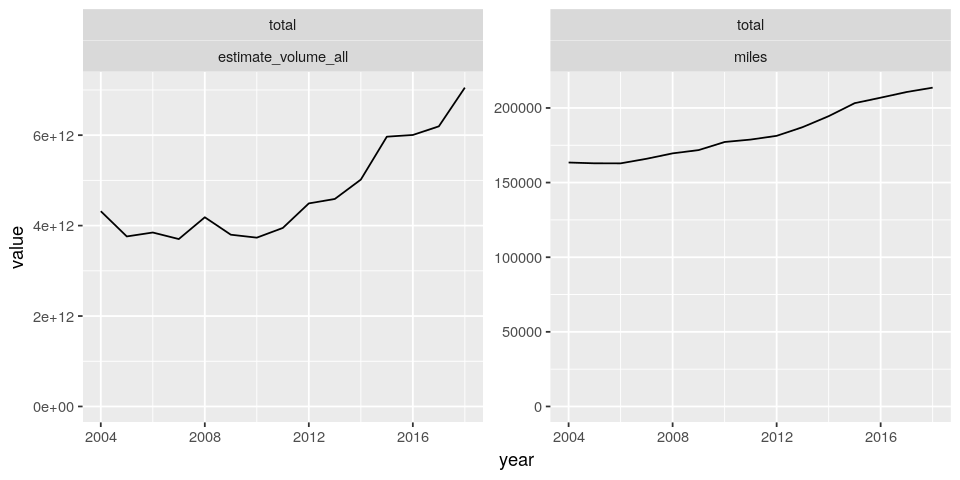

In [9]:
details_v_m

The comparison shows that the uptick in volume transported is much more significant than that in pipeline miles. Existing pipelines are used to transport more oil, or pipelines with larger diameters are used, supposedly because of the fracking boom.